In [1]:
import torch
import numpy

In [5]:
x = torch.ones(1)
x.requires_grad
x.requires_grad_(True)

tensor([1.], requires_grad=True)

In [32]:
x = torch.arange(3, dtype=torch.float, requires_grad=True)
print(x)

tensor([0., 1., 2.], requires_grad=True)


In [33]:
a = x+2
a.retain_grad()
b = torch.pow(a, 2)
c = b+3
d = torch.mean(c)
print(d)

tensor(12.6667, grad_fn=<MeanBackward0>)


In [34]:
d.backward()

In [35]:
x.grad

tensor([1.3333, 2.0000, 2.6667])

In [36]:
a.grad

tensor([1.3333, 2.0000, 2.6667])

In [37]:
b.grad

C:\Users\Jaewoo Lee\AppData\Local\Temp\ipykernel_9396\3238518479.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:485.)
  b.grad


In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [42]:
x = torch.Tensor(2,3)
x.to(device)

tensor([[4.2882e-08, 7.9961e+20, 5.3776e+22],
        [2.1863e+23, 5.1205e-11, 4.2330e+21]])

In [43]:
import torch.nn as nn
import torch.nn.functional as F

In [44]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs):
        super().__init__()
        self.linear1 = nn.Linear(num_inputs, num_hiddens)
        self.linear2 = nn.Linear(num_hiddens, num_outputs)
        self.tanh = nn.Tanh()
    
    def forward(self, x):
        return self.linear2(self.tanh(self.linear1(x)))

In [45]:
model = SimpleClassifier(2, 4, 1)

In [50]:
for name, parameter in model.named_parameters():
    print(f'{name} - {parameter.shape}')

linear1.weight - torch.Size([4, 2])
linear1.bias - torch.Size([4])
linear2.weight - torch.Size([1, 4])
linear2.bias - torch.Size([1])


In [119]:
import torch.utils.data as data
import matplotlib.pyplot as plt

In [124]:
class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()
    
    def generate_continuous_xor(self):
        self.data = torch.randint(low=0, high=2, size=(self.size,2), dtype=torch.float)
        self.label = (self.data.sum(axis=-1)==1).to(torch.long)
        self.data += self.std*torch.randn((self.size,2))
        
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label
    
    def vis(self):
        data0 = self.data[self.label == 0]
        data1 = self.data[self.label == 1]
        plt.figure(figsize=(4,4))
        plt.grid()
        plt.scatter(data0[:,0], data0[:,1], label='Class 0', edgecolor='#333', alpha=0.25)
        plt.scatter(data1[:,0], data1[:,1], label='Class 1', edgecolor='#333', alpha=0.25)
        plt.legend()
        plt.show()

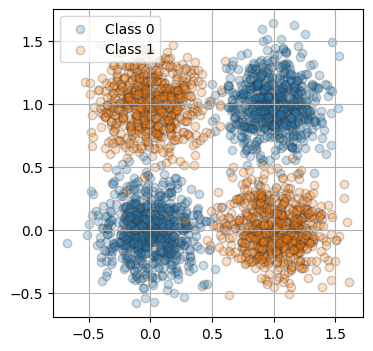

In [214]:
dataset = XORDataset(2500, std=0.2)
test_dataset = XORDataset(500, std=0.2)

dataloader = data.DataLoader(dataset, batch_size=32, shuffle=False)
test_dataloader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)
model = SimpleClassifier(2,50,1)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)
loss_func = nn.BCEWithLogitsLoss()

dataset.vis()

In [220]:
from tqdm import tqdm
from matplotlib.colors import to_rgba

def evaluation(model, dataloader, loss_func):
    model.eval()
    tp=0.
    total=0.
    
    with torch.no_grad():
        for d, l in dataloader:
            preds = model(d).squeeze(dim=1)
            preds = torch.sigmoid(preds)
            pred_labels = (preds>=0.5).long()
            tp += (pred_labels==l).sum()
            total += pred_labels.shape[0]
            print(tp, total)
    acc = tp/total
    print(f'acc : {acc}')

def train(model, dataloader, optimizer, loss_func):
    for i in tqdm(range(int(len(dataset)/dataloader.batch_size))):
        for d, l in dataloader:
            preds = model(d).squeeze(dim=1)
            loss = loss_func(preds, l.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    evaluation(model, test_dataloader, loss_func)
    

def visualize_classification(model, data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    fig = plt.figure(figsize=(4,4), dpi=500)
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

    # Let's make use of a lot of operations we have learned above
    model.to(device)
    c0 = torch.Tensor(to_rgba("C0")).to(device)
    c1 = torch.Tensor(to_rgba("C1")).to(device)
    x1 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    x2 = torch.arange(-0.5, 1.5, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    preds = model(model_inputs)
    preds = torch.sigmoid(preds)
    output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
    output_image = output_image.cpu().detach().numpy()  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
    plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
    plt.grid(False)
    return fig

100%|██████████████████████████████████████████████████████████████████████████████████| 78/78 [00:04<00:00, 15.83it/s]


tensor(30.) 32.0
tensor(62.) 64.0
tensor(94.) 96.0
tensor(126.) 128.0
tensor(158.) 160.0
tensor(190.) 192.0
tensor(222.) 224.0
tensor(253.) 256.0
tensor(284.) 288.0
tensor(315.) 320.0
tensor(347.) 352.0
tensor(378.) 384.0
tensor(410.) 416.0
tensor(441.) 448.0
tensor(472.) 480.0
tensor(491.) 500.0
acc : 0.9819999933242798


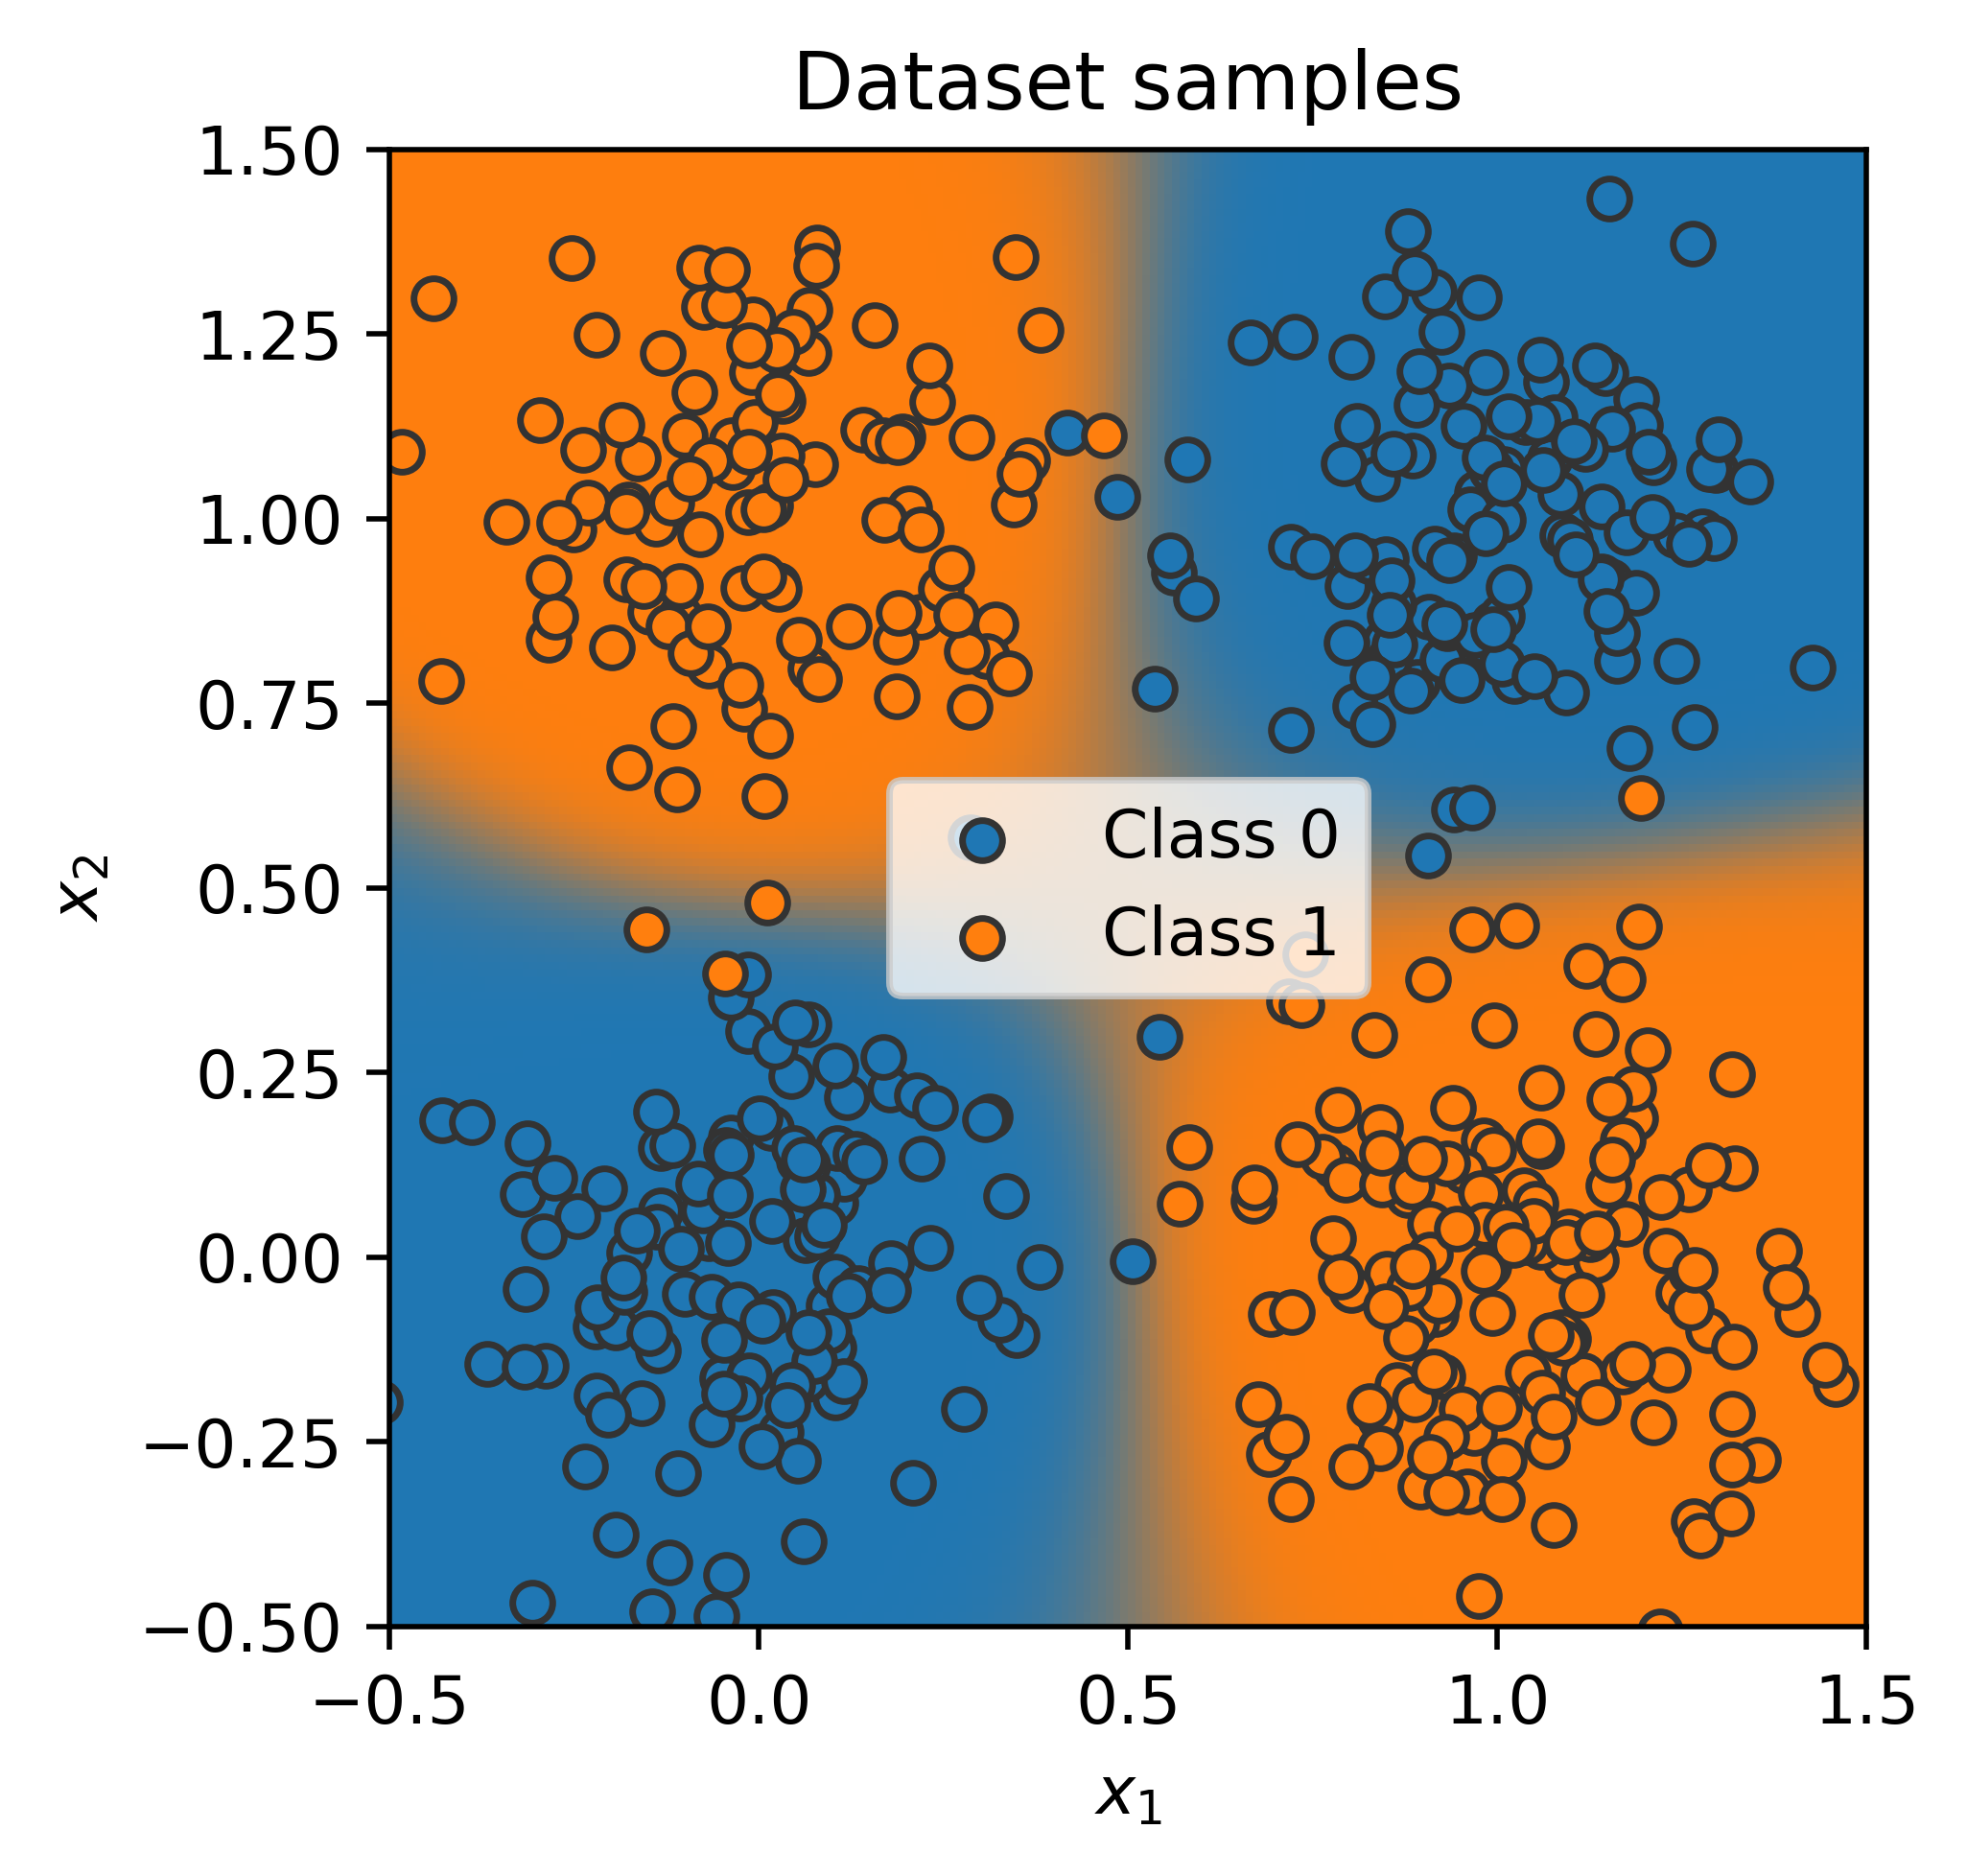

In [222]:
train(model, dataloader, optimizer, loss_func)
_ = visualize_classification(model, test_dataset.data, test_dataset.label)
plt.show()

In [225]:
torch.save(model.state_dict(), 'first_model.tar')

In [228]:
state_dict = torch.load('first_model.tar')
new_model = SimpleClassifier(2,50,1)
new_model.load_state_dict(state_dict)

<All keys matched successfully>

In [234]:
from torch.utils.tensorboard import SummaryWriter

In [235]:
%load_ext tensorboard